In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
)
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Annotated
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
from dotenv import load_dotenv 
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import RetryOutputParser
import os.path
import base64
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from email.message import EmailMessage
from langgraph.store.memory import InMemoryStore


load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')

In [10]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [11]:
class State(TypedDict):
    """
    A dictionnary representing the state of the agent.
    """
    node_message:str
    query: str
    inbox: dict
    current_draft: dict
    drafts: dict
    inbox_max_results: int
    route:str

In [12]:
store=InMemoryStore()

In [13]:
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")
try:
    # create gmail api client
    service = build("gmail", "v1", credentials=creds)

except HttpError as error:
    print(f"An error occurred: {error}")

In [14]:
def agent_node(state:State):
    class Route(BaseModel):
            route: str = Field(description="the route for the next node, either, display_email, send_email, verify_draft, create_email, show_inbox, get_new_mail or END")
            inbox_max_results: int = Field(description="the number of results to get")
            


    parser=JsonOutputParser(pydantic_object=Route)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
      )

      
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'choose the route based on this query: {state.get('query')}, if the number of results is not mentionned in the query, set it to 5 '}) 
    try:
        response=parser.parse(response.content)
        return {'route':response.get('route'),
               'inbox_max_results':response.get('inbox_max_results')}
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)
        return {'route':response.get('route'),
               'inbox_max_results':response.get('inbox_max_results')} 

In [15]:
# class Route(BaseModel):
#     route: str = Field(description="the route for the next node, either, display_email, send_email, verify_draft, create_email, show_inbox, get_new_mail or END")
#     inbox_max_results: int = Field(description="the number of results to get")
        


# parser=JsonOutputParser(pydantic_object=Route)
# prompt = PromptTemplate(
# template="Answer the user query.\n{format_instructions}\n{query}\n",
# input_variables=["query"],
# partial_variables={"format_instructions": parser.get_format_instructions()},
#     )

    
# chain = prompt | llm 

# response=chain.invoke({'query':f'choose the route based on this query: , if the number of results is not mentionned in the query, set it to 5 '}) 
# try:
#     response=parser.parse(response.content)
    

In [ ]:

def get_new_mail_node(state: State):
    maxResults=state.get('inbox_max_results')
    if maxResults:
        ids=service.users().messages().list(userId='me', includeSpamTrash=False , maxResults=maxResults).execute().get('messages',[])
    else:
        ids=service.users().messages().list(userId='me', includeSpamTrash=False , maxResults=5).execute().get('messages',[])
    messages={}

    for id in ids:
        mdata=service.users().messages().get(userId="me", id=id["id"], format='full' ).execute()
        id=mdata.get('id')
        thread=mdata.get('threadId')
        label=mdata.get('labelIds')
        headers={h.get('name'):h.get('value') for h in mdata.get('payload').get('headers')}
        sender=headers.get('From')
        date=headers.get('Date')
        receiver=headers.get('To')
        subject=headers.get('Subject')
        snippet=mdata.get('snippet')

        messages[id]={'From':sender,
                    'To':receiver,
                    'Date':date,
                    'label':label,
                    'subject':subject,
                    'Snippet':snippet,
                    'email_id':id,
                    'thread':thread
                  
                    }  
    return {'inbox':messages}

In [17]:

def create_email_node(state:State):
      class EmailInput(BaseModel):
            receiver: str = Field(description="Email address of the recipient")
            content: str = Field(description="Body content of the email")
            email_subject: str = Field(description="Subject line of the email")


      parser=JsonOutputParser(pydantic_object=EmailInput)
      prompt = PromptTemplate(
      template="Answer the user query.\n{format_instructions}\n{query}\n",
      input_variables=["query"],
      partial_variables={"format_instructions": parser.get_format_instructions()},
      )

      
      chain = prompt | llm 
     
      response=chain.invoke({'query':f'create an email based on this query: {state.get('query')}'}) 
      try:
            response=parser.parse(response.content)
            
      except:
            
            retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

            prompt_value = prompt.format_prompt(query=state['query'])
            response=retry_parser.parse_with_prompt(response.content, prompt_value) 
 
      message = EmailMessage()

      message.set_content(response.get('content'))

      message["To"] = response.get('receiver')
      message["From"] = "me"
      message["Subject"] = response.get('email_subject')

      # encoded message
      encoded_message = base64.urlsafe_b64encode(message.as_bytes()).decode()
      
      create_message = {"raw": encoded_message}
      return{'current_draft':create_message}
                  

            

In [18]:

def verify_draft_node(state:State):
    """tool to verify the current draft
    
    args: none
    """
    try:
        create_message=state['current_draft']
        decoded=base64.urlsafe_b64decode(create_message.get('raw').encode("utf-8")).decode("utf-8")
        return {'node_message':decoded}
    except:
        return {'node_message':'Failed'}

In [19]:
def send_email_node(state:State):
    """
    Tool to send the current draft
    args: - none
    """
    try:
        create_message=state['current_draft']
        # pylint: disable=E1101
        send_message = (
            service.users()
            .messages()
            .send(userId="me", body=create_message)
            .execute()
        )
        return {'node_message':'Email Sent'}
    except:
        return {'node_message':'Failed'}

In [20]:

def show_inbox_node(state: State):
    return {'node_message': state.get('inbox')}
    
        

In [21]:
def router(state:State):
    route = state.get('route')
    
    routing_map = {
        'display_email': 'to_display_email',
        'send_email': 'to_send_email',
        'verify_draft': 'to_verify_draft',
        'create_email': 'to_create_email',
        'show_inbox': 'to_show_inbox',
        'get_new_mail': 'to_get_new_mail',
        'END': 'to_end'
    }
    
    return routing_map.get(route)

In [22]:

def display_email_node(state:State):
    class EmailID(BaseModel):
        id: str = Field(description="The ID of the Email to display")


    parser=JsonOutputParser(pydantic_object=EmailID)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'get the id of the email to show from the inbox: {state.get('inbox')}, based on this query: {state.get('query')}'}) 
    try:
        response=parser.parse(response.content)
        
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)

    
    try:
        mdata=service.users().messages().get(userId="me", id=response.get('id'), format='full' ).execute()
        id=mdata.get('id')
        thread=mdata.get('threadId')
        label=mdata.get('labelIds')
        headers={h.get('name'):h.get('value') for h in mdata.get('payload').get('headers')}
        sender=headers.get('From')
        date=headers.get('Date')
        receiver=headers.get('To')
        subject=headers.get('Subject')
        snippet=mdata.get('snippet')
        try:
            body=base64.urlsafe_b64decode(mdata['payload']['parts'][0]['body']['data'].encode("utf-8")).decode("utf-8")
        except:
            try:

                body=base64.urlsafe_b64decode(mdata['payload']['parts'][0]['parts'][0]['body']['data'].encode("utf-8")).decode("utf-8")
            except:
                    body=base64.urlsafe_b64decode(mdata['payload']['body']['data'].encode("utf-8")).decode("utf-8")
              
        messages={'From':sender,
        'To':receiver,
        'Date':date,
        'label':label,
        'subject':subject,
        'Snippet':snippet,
        'email_id':id,
        'thread':thread,
        'body':body
        }

        return {'node_message':messages}
    except: 
        return {'node_message':'failed'}

In [23]:
class gmail_agent:
    def __init__(self,llm : any):
        self.agent=self._setup(llm)
    def _setup(self,llm):
    
        graph_builder = StateGraph(State)
        graph_builder.add_node("display_email", display_email_node)
        graph_builder.add_node('send_email',send_email_node)
        graph_builder.add_node('verify_draft',verify_draft_node)
        graph_builder.add_node('create_email', create_email_node)
        graph_builder.add_node("show_inbox", show_inbox_node)
        graph_builder.add_node('agent',agent_node)
        graph_builder.add_node('get_new_mail',get_new_mail_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.set_entry_point("get_new_mail")
        graph_builder.add_edge("get_new_mail", "agent")
        graph_builder.add_conditional_edges(
            "agent",
            router, {
                    'to_display_email': 'display_email',
                    'to_send_email': 'send_email',
                    'to_verify_draft': 'verify_draft',
                    'to_create_email': 'create_email',
                    'to_show_inbox': 'show_inbox',
                    'to_get_new_mail': 'get_new_mail',
                    'to_end':END
                }
        )
        graph_builder.add_edge("display_email", END)
        graph_builder.add_edge('send_email',END)
        graph_builder.add_edge('verify_draft',END)
        graph_builder.add_edge('create_email', END)
        graph_builder.add_edge("show_inbox", END)
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory,store=store)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input
                                    },config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input
                                        }, config, stream_mode="updates"):
            print(event)
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

In [24]:
agent=gmail_agent(llm)

In [28]:
agent.stream('display the email from maxwell tribeca')

{'get_new_mail': {'inbox': {'1958fd30daa09f04': {'From': 'Maxwell Tribeca <info@maxwellsocial.com>', 'To': 'padioutristan@gmail.com', 'Date': 'Thu, 13 Mar 2025 14:05:26 +0000 (UTC)', 'label': ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX'], 'subject': "Announcing the Spring '25 Cohort!", 'Snippet': 'Spring Cohort Applications are Open! \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c \u200c', 'email_id': '1958fd30daa09f04', 'thread': '1958fd30daa09f04'}, '1958f9d761645f19': {'From':

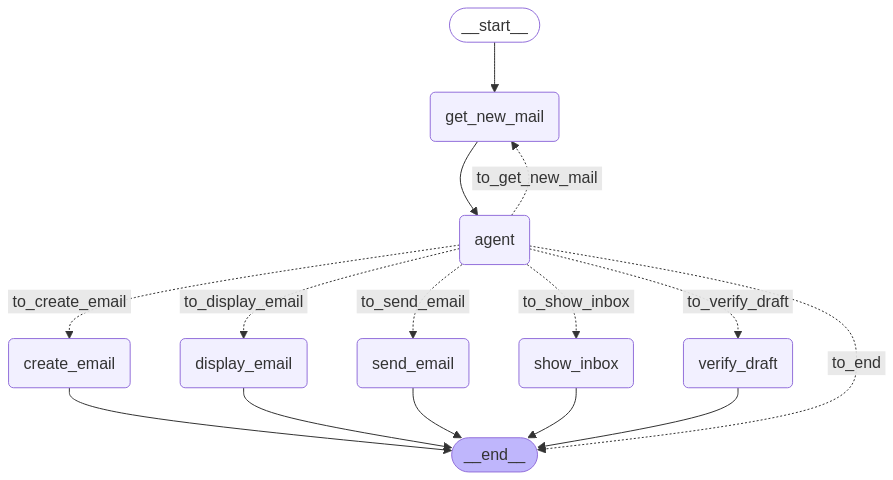

In [26]:
agent.display_graph() 

In [27]:
agent.get_state('current_draft')

KeyError: 'current_draft'